In [25]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import joblib

In [26]:
df = pd.read_csv("../data/patient_segmentation_dataset.csv")

In [27]:
y = df["Preventive_Care_Flag"]
X = df.drop(columns=["Preventive_Care_Flag"])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [29]:
num_cols = [
    "Age", "Height_cm", "Weight_kg", "BMI",
    "Num_Chronic_Conditions", "Annual_Visits",
    "Avg_Billing_Amount", "Days_Since_Last_Visit"
]

cat_cols = ["Gender", "State", "City", "Insurance_Type", "Primary_Condition"]
drop_cols = ["PatientID", "Last_Visit_Date"]  

In [30]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
        ("drop", "drop", drop_cols)
    ]
)

XGBoost ROC-AUC: 0.5225605466787258
              precision    recall  f1-score   support

           0       0.54      0.60      0.57       214
           1       0.48      0.42      0.45       186

    accuracy                           0.52       400
   macro avg       0.51      0.51      0.51       400
weighted avg       0.51      0.52      0.51       400



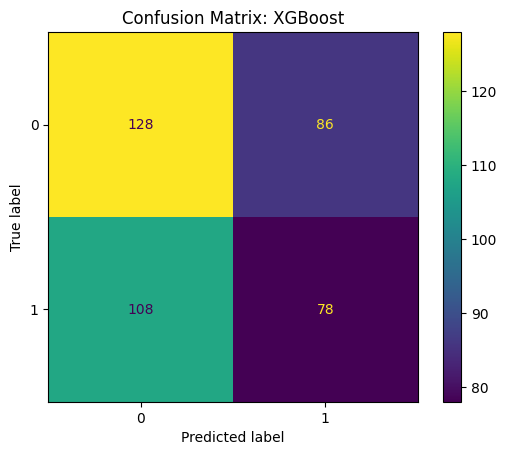

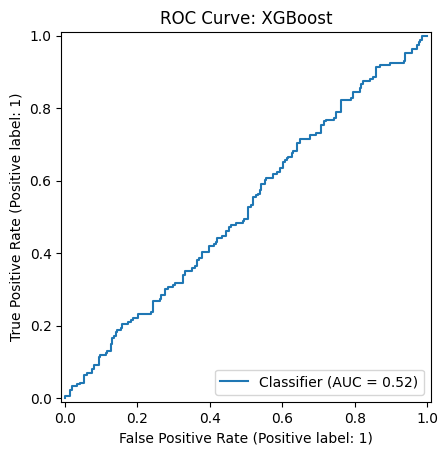

In [31]:
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric="logloss"
)

xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_model)
])

xgb_pipeline.fit(X_train, y_train)

pred = xgb_pipeline.predict(X_test)
proba = xgb_pipeline.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, proba)
print("XGBoost ROC-AUC:", auc)
print(classification_report(y_test, pred))

cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix: XGBoost")
plt.show()

RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC Curve: XGBoost")
plt.show()

In [32]:
param_grid = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0]
}

In [33]:
xgb_tune = XGBClassifier(
    random_state=42,
    eval_metric="logloss"
)

xgb_tune_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", xgb_tune)
])

grid = GridSearchCV(
    estimator=xgb_tune_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best ROC-AUC (CV):", grid.best_score_)
print("Best Params:", grid.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best ROC-AUC (CV): 0.5705952837412671
Best Params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 1.0}


Best XGBoost ROC-AUC (Test): 0.574062908250427
              precision    recall  f1-score   support

           0       0.58      0.72      0.64       214
           1       0.55      0.39      0.46       186

    accuracy                           0.57       400
   macro avg       0.56      0.56      0.55       400
weighted avg       0.56      0.57      0.56       400



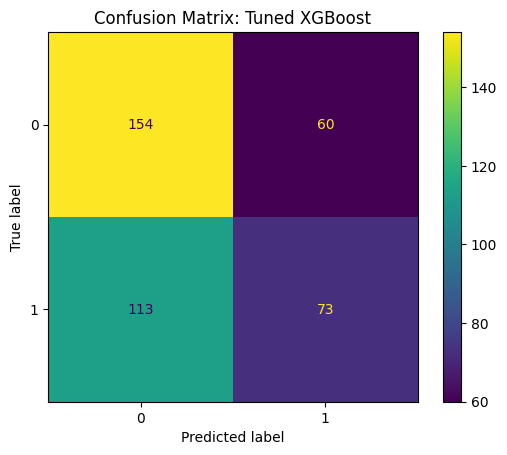

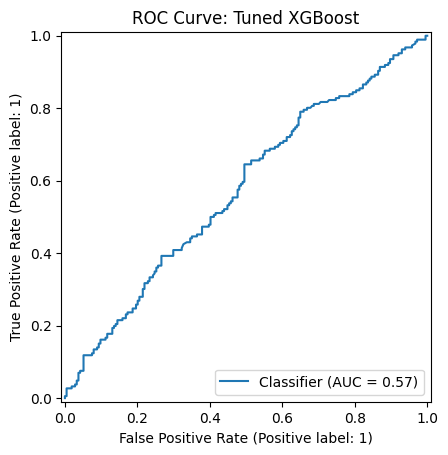

In [34]:
best_model = grid.best_estimator_

pred = best_model.predict(X_test)
proba = best_model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, proba)
print("Best XGBoost ROC-AUC (Test):", auc)
print(classification_report(y_test, pred))

cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix: Tuned XGBoost")
plt.show()

RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC Curve: Tuned XGBoost")
plt.show()

In [35]:
import joblib
joblib.dump(best_model, "../models/model.joblib")
print("Saved tuned XGBoost model to ../models/model.joblib")

Saved tuned XGBoost model to ../models/model.joblib


In [36]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    )
}

MODEL: LogisticRegression
ROC-AUC: 0.5609988945834589
              precision    recall  f1-score   support

           0       0.57      0.67      0.62       214
           1       0.52      0.42      0.47       186

    accuracy                           0.55       400
   macro avg       0.55      0.54      0.54       400
weighted avg       0.55      0.55      0.55       400



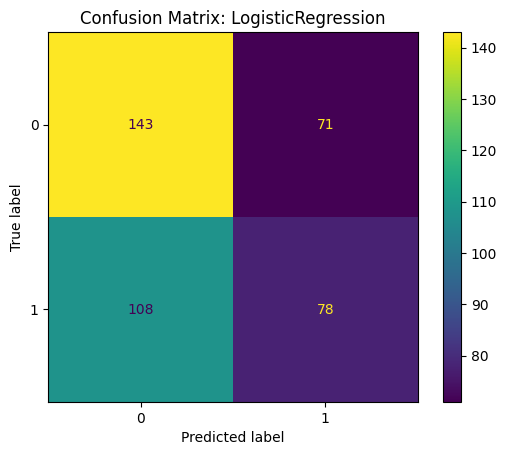

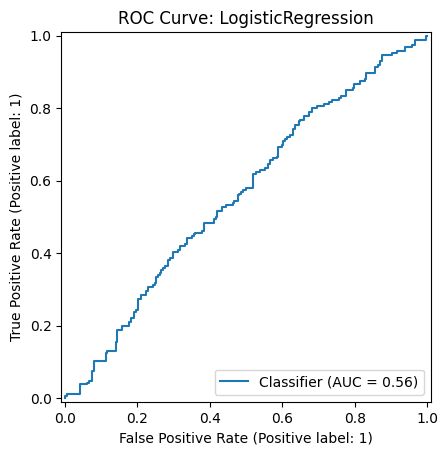

MODEL: RandomForest
ROC-AUC: 0.5762486182293236
              precision    recall  f1-score   support

           0       0.58      0.66      0.62       214
           1       0.54      0.46      0.49       186

    accuracy                           0.56       400
   macro avg       0.56      0.56      0.56       400
weighted avg       0.56      0.56      0.56       400



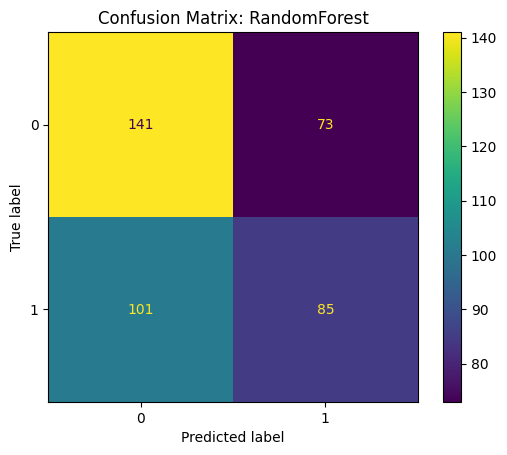

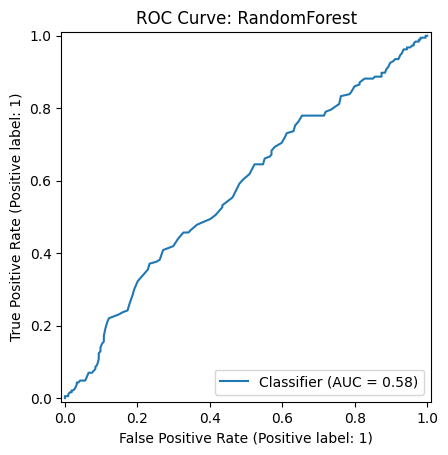


Summary ROC-AUC:
('LogisticRegression', np.float64(0.5609988945834589))
('RandomForest', np.float64(0.5762486182293236))


In [37]:
results = []

for name, model in models.items():
    clf = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])
    
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    proba = clf.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, proba)
    results.append((name, auc))
    
    print("="*60)
    print("MODEL:", name)
    print("ROC-AUC:", auc)
    print(classification_report(y_test, pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix: {name}")
    plt.show()
    
    # ROC Curve
    RocCurveDisplay.from_predictions(y_test, proba)
    plt.title(f"ROC Curve: {name}")
    plt.show()

print("\nSummary ROC-AUC:")
for r in results:
    print(r)

Top 15 Important Features:


,feature,importance
6,Avg_Billing_Amount,0.105495
7,Days_Since_Last_Visit,0.104421
3,BMI,0.099813
0,Age,0.092998
2,Weight_kg,0.092777
1,Height_cm,0.089387
5,Annual_Visits,0.063380
4,Num_Chronic_Conditions,0.023896
8,Gender_Female,0.013773
42,Insurance_Type_Private,0.013360


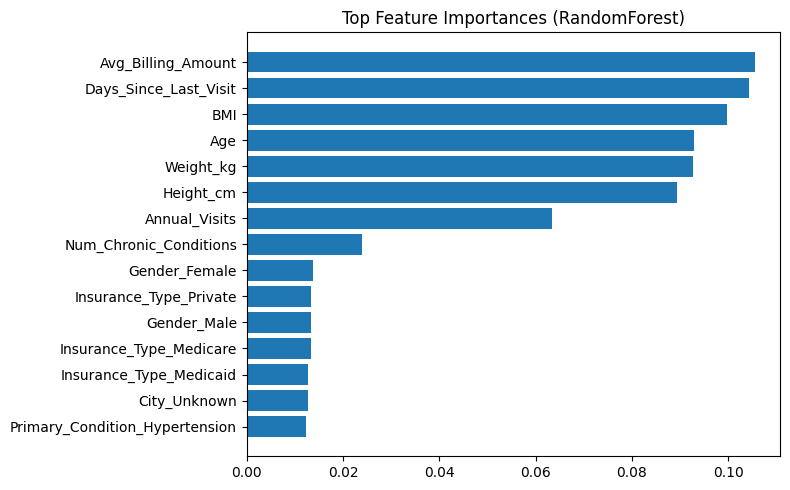

In [38]:
# Train RF again to get feature importance
rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    ))
])

rf_pipeline.fit(X_train, y_train)

# get feature names after one-hot
ohe = rf_pipeline.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_feature_names])

importances = rf_pipeline.named_steps["model"].feature_importances_
fi = pd.DataFrame({"feature": feature_names, "importance": importances})
fi = fi.sort_values("importance", ascending=False).head(15)

print("Top 15 Important Features:")
display(fi)

plt.figure(figsize=(8, 5))
plt.barh(fi["feature"][::-1], fi["importance"][::-1])
plt.title("Top Feature Importances (RandomForest)")
plt.tight_layout()
plt.show()

In [39]:
import joblib
joblib.dump(rf_pipeline, "../models/model.joblib")
print("Saved model to ../models/model.joblib")

Saved model to ../models/model.joblib


In [40]:
import sys
print(sys.executable)

c:\Users\user\AppData\Local\Programs\Python\Python311\python.exe


In [41]:
import sys
!{sys.executable} -m pip install shap


[notice] A new release of pip is available: 25.0.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
import shap
print(shap.__version__)

0.50.0


In [43]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# best_model = grid.best_estimator_
preprocessor = best_model.named_steps["preprocess"]
xgb_clf = best_model.named_steps["model"]

# Transform data (X_test -> numeric matrix)
X_test_transformed = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
num_cols = [
    "Age", "Height_cm", "Weight_kg", "BMI",
    "Num_Chronic_Conditions", "Annual_Visits",
    "Avg_Billing_Amount", "Days_Since_Last_Visit"
]
cat_cols = ["Gender", "State", "City", "Insurance_Type", "Primary_Condition"]
ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

feature_names = preprocessor.get_feature_names_out()
# Make DataFrame for SHAP
X_test_shap = pd.DataFrame(X_test_transformed, columns=feature_names)


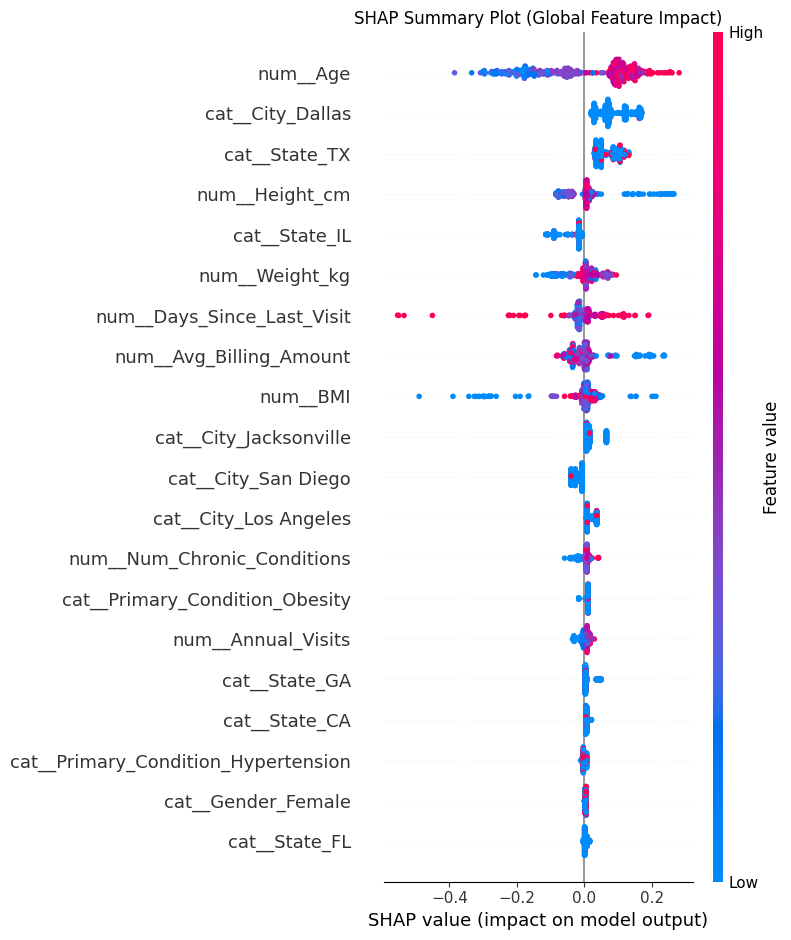

In [44]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test_shap)

# Summary plot (global explain)
shap.summary_plot(shap_values, X_test_shap, show=False)
plt.title("SHAP Summary Plot (Global Feature Impact)")
plt.tight_layout()
plt.show()


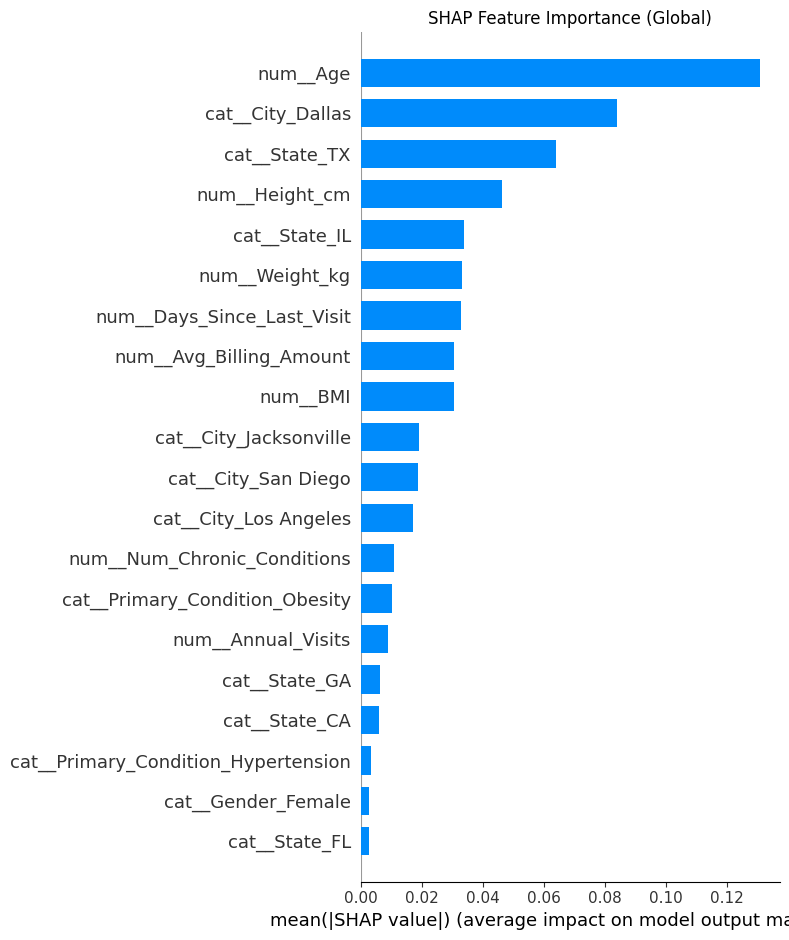

In [45]:
shap.summary_plot(shap_values, X_test_shap, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Global)")
plt.tight_layout()
plt.show()


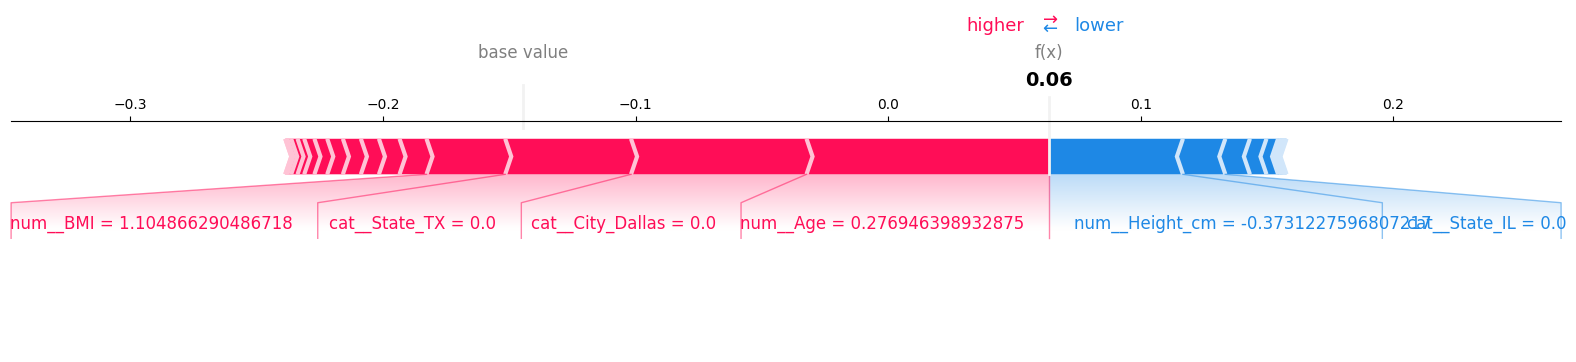

In [46]:
idx = 0 
shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X_test_shap.iloc[idx],
    matplotlib=True
)
plt.show()


In [47]:
shap.summary_plot(shap_values, X_test_shap, show=False)
plt.tight_layout()
plt.savefig("../models/shap_summary.png", dpi=200)
plt.close()

shap.summary_plot(shap_values, X_test_shap, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig("../models/shap_bar.png", dpi=200)
plt.close()

print("Saved SHAP plots to ../models/")

Saved SHAP plots to ../models/


In [48]:
importances = xgb_clf.feature_importances_
fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

fi.head(20)
fi.to_csv("../models/feature_importance.csv", index=False)
print("Saved feature importance to ../models/feature_importance.csv")

Saved feature importance to ../models/feature_importance.csv
